In [1]:
import sys
sys.path.append('..')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pickle
import numpy as np
import bokeh

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from utils.draw_utils import draw_gt_reaction
from utils.dataset_utils import prune_dataset_by_length
from MulticoreTSNE import MulticoreTSNE as TSNE
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
from collections import Counter, OrderedDict

from scipy.spatial.distance import cosine
from IPython.display import display

IPythonConsole.molSize = (300,300)

RDKit WARNING: [21:43:16] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

In [39]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, LassoSelectTool, PanTool 
from bokeh.models.widgets import Panel, Tabs                     
from bokeh.io import output_notebook
from bokeh.palettes import d3
from bokeh.embed import components

In [7]:
test_dataset = pickle.load(open('../data/USPTO_50k/dataset.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, 150)

In [8]:
reac_reps = pickle.load(open('../data/data_visualisation/original_embeddings.pkl', 'rb'))
idxs, embed = zip(*reac_reps.items())
reac_reps = np.c_[embed].T

In [9]:
classes = [test_dataset[idx]['class'] for idx in idxs]
class2count = OrderedDict(Counter(classes).most_common(10))
classes = np.array(classes)

In [10]:
class_names = {1: 'Heteroatom alkilation\n and arylation',
               2: 'Acylation and\n related processes', 
               3: 'C-C bond formation', 
               4: 'Heterocycle formation', 
               5: 'Protections', 
               6: 'Deprotections', 
               7: 'Reduction', 
               8: 'Oxidation', 
               9: 'Functional group\n interconversation', 
               10: 'Functioanal group\n adding'}

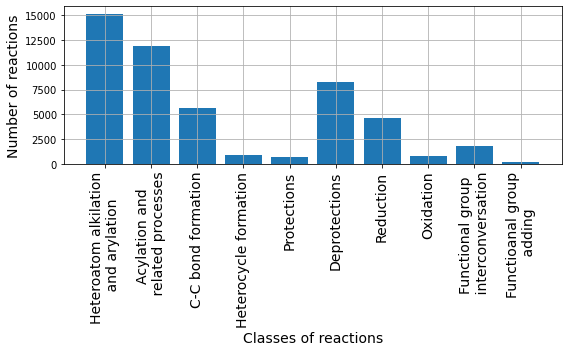

In [11]:
plt.figure(figsize=(8, 5))
plt.bar(list(class2count.keys()), list(class2count.values()), align='center', width = 0.8)
plt.grid()
plt.xlabel('Classes of reactions', fontsize=14)
plt.ylabel('Number of reactions', fontsize=14)
plt.xticks(list(class_names.keys()), list(class_names.values()), rotation='vertical',  fontsize=14)
plt.tight_layout()
plt.savefig('class_dist.png', dpi=300)
plt.show()

In [12]:
minor_idx = [4, 5, 8, 9, 10]
main_idx = [1, 2, 3, 6, 7]
minor_cls = classes[np.isin(classes, minor_idx)]
main_cls = classes[np.isin(classes, main_idx)]
reac_reps_main = reac_reps[np.isin(classes, main_idx)]
reac_reps_minor = reac_reps[np.isin(classes, minor_idx)]

In [13]:
full_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps)
main_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps_main)
minor_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps_minor)

In [14]:
back = '#aaaaaa'
minor_colors = {8: '#173f5f', 4: '#20639b', 5: '#3caea3', 9: '#f6d55c', 10: '#ed553b'}
main_colors = {7: '#173f5f', 2: '#20639b', 6: '#3caea3', 1: '#f6d55c', 3: '#ed553b'}

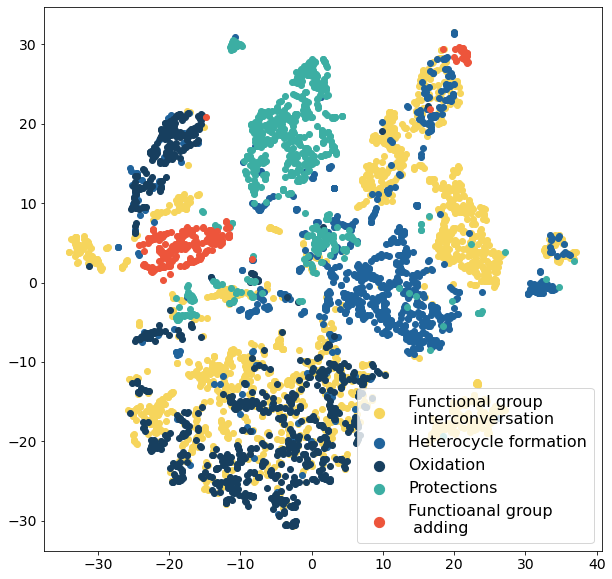

In [15]:
plt.figure(figsize=(10, 10))
scatters = {}
for c in [9, 4,  8, 5, 10]:
    x = minor_2d[:, 0][minor_cls == c]
    y = minor_2d[:, 1][minor_cls == c]
    colors = minor_cls[minor_cls == c]
    scatters[c] = plt.scatter(x, y, c=minor_colors[c])
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=16, markerscale=1.7, loc='best', ncol=1)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.savefig('tsne_minor.png', dpi=300)
plt.show()

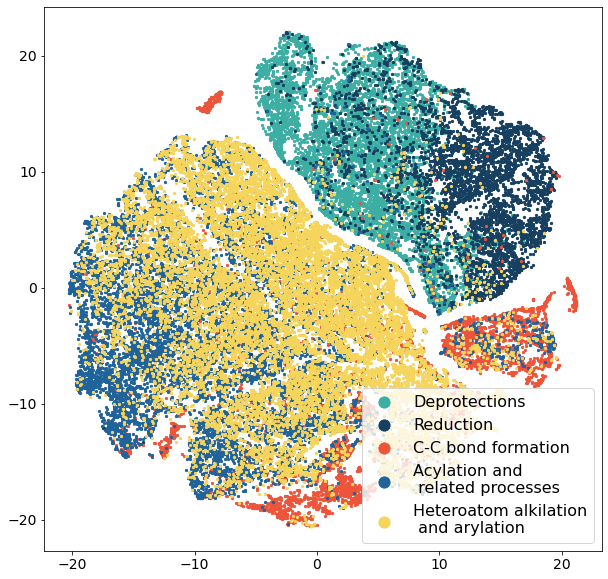

In [16]:
plt.figure(figsize=(10, 10))
scatters = {}
for c in [6, 7, 3, 2, 1]:
    x = main_2d[:, 0][main_cls == c]
    y = main_2d[:, 1][main_cls == c]
    colors = main_cls[main_cls == c]
    scatters[c] = plt.scatter(x, y, c=main_colors[c], s=5)
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=16, markerscale=5., loc='lower right')
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.savefig('tsne_main.png', dpi=300)
plt.show()

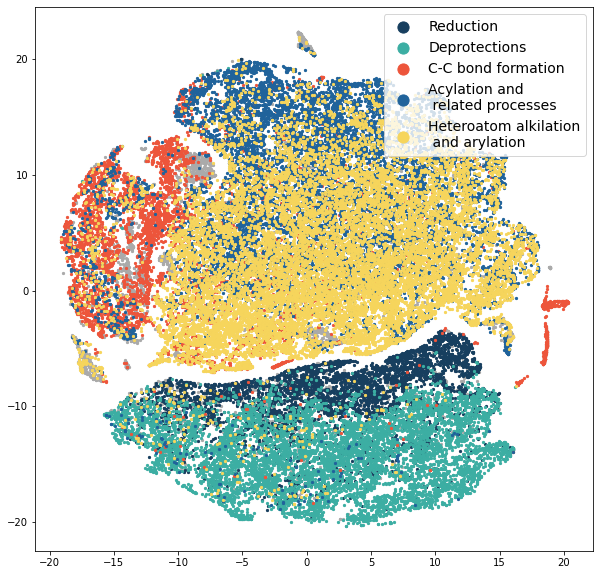

In [17]:
plt.figure(figsize=(10, 10))
scatters = {}
x = full_2d[:, 0][np.isin(classes, minor_idx)]
y = full_2d[:, 1][np.isin(classes, minor_idx)]
plt.scatter(x, y, c=back, s=5)
main_2d_ = full_2d[np.isin(classes, main_idx)]
for c in [7, 6, 3, 2, 1]:
    x = main_2d_[:, 0][main_cls == c]
    y = main_2d_[:, 1][main_cls == c]
    colors = main_cls[main_cls == c]
    scatters[c] = plt.scatter(x, y, c=main_colors[c], s=5)
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=14, markerscale=5.)
#plt.savefig('tsne_main_gray.png', dpi=300)
plt.show()

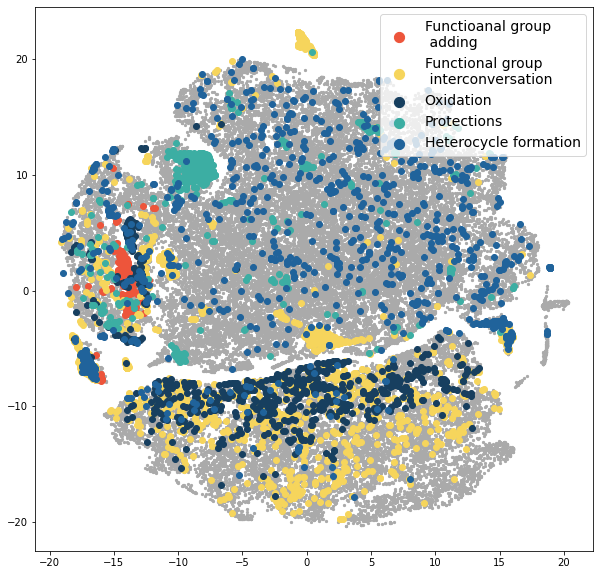

In [18]:
plt.figure(figsize=(10, 10))
scatters = {}
x = full_2d[:, 0][np.isin(classes, main_idx)]
y = full_2d[:, 1][np.isin(classes, main_idx)]
plt.scatter(x, y, c=back, s=5)
minor_2d_ = full_2d[np.isin(classes, minor_idx)]
for c in [10, 9, 8, 5, 4]:
    x = minor_2d_[:, 0][minor_cls == c]
    y = minor_2d_[:, 1][minor_cls == c]
    colors = minor_cls[minor_cls == c]
    scatters[c] = plt.scatter(x, y, c=minor_colors[c])
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=14, markerscale=1.7)
#plt.savefig('tsne_minor_gray.png', dpi=300)
plt.show()

In [19]:
minor_idxs = np.array(idxs)[np.isin(classes, minor_idx)]
main_idxs = np.array(idxs)[np.isin(classes, main_idx)]
n_main_show = 5000
show_idxs = np.unique(np.random.randint(0, len(main_idxs), n_main_show, ))
main_idxs = main_idxs[show_idxs]

In [79]:
prefix = 'imgs/uspto_50k/'
#prefix = '../server/static/imgs/uspto_50k/'

In [80]:
minor_r_paths = [f'{prefix}{idx}_r.svg' for idx in minor_idxs]
minor_p_paths = [f'{prefix}{idx}_p.svg' for idx in minor_idxs]
main_r_paths = [f'{prefix}{idx}_r.svg' for idx in main_idxs]
main_p_paths = [f'{prefix}{idx}_p.svg' for idx in main_idxs]

In [81]:
minor_c = [minor_colors[classes[i]] for i in minor_idxs]
main_c = [main_colors[classes[i]] for i in main_idxs]
minor_labels = [class_names[classes[i]] for i in minor_idxs]
main_labels = [class_names[classes[i]] for i in main_idxs]

In [83]:
output_file("tsne.html")

source = ColumnDataSource(
        data=dict(
            x=minor_2d[:, 0],
            y=minor_2d[:, 1],
            r_imgs = minor_r_paths,
            p_imgs = minor_p_paths, 
            c = minor_c, 
            label = minor_labels,
        )
    )
hover = HoverTool(
        tooltips="""
            <div class="row">
                  <div class="column">
                      <embed type="image/svg+xml" src="@r_imgs" />
                  </div>
                  <div class="column">
                      <embed type="image/svg+xml" src="@p_imgs" />
                  </div>
            </div>
            """
    )

p1 = figure(plot_width=600, plot_height=600, tools=[hover, BoxZoomTool(), ResetTool(), LassoSelectTool(), PanTool()],
           title="Embedding of reactions in 2D space", margin=0)

p1.circle('x', 'y', size=6, source=source, color={'field': 'c'}, legend_group='label')


tab1 = Panel(child=p1, title='Minor classes of reactions')

source = ColumnDataSource(
        data=dict(
            x=main_2d[:, 0][show_idxs],
            y=main_2d[:, 1][show_idxs],
            r_imgs = main_r_paths,
            p_imgs = main_p_paths, 
            c = main_c, 
            label = main_labels,
        )
    )
hover = HoverTool(
        tooltips="""
            <div class="row">
                  <div class="column">
                      <embed type="image/svg+xml" src="@r_imgs" />
                  </div>
                  <div class="column">
                      <embed type="image/svg+xml" src="@p_imgs" />
                  </div>
            </div>
            """
    )

p2 = figure(plot_width=600, plot_height=600, tools=[hover, BoxZoomTool(), ResetTool(), LassoSelectTool(), PanTool()],
           title="Embedding of reactions in 2D space", margin=0)

p2.circle('x', 'y', size=6, source=source, color={'field': 'c'}, legend_group='label')

tab2 = Panel(child=p2, title='Major classes of reactions')

tabs = Tabs(tabs=[ tab1, tab2 ])

#show(tabs)

In [84]:
script, div = components(tabs)

In [85]:
with open('tsne.js', 'w') as f:
    f.write('\n'.join(script.split('\n')[2:-1]))

In [86]:
print(div)


<div class="bk-root" id="7c58ad02-cded-4f14-b8d0-881853c23c3c" data-root-id="12575"></div>


In [27]:
def show_k_reactants(dataset, norms, indexes,):
    keys = list(dataset.keys())
    for idx in indexes:
        print(keys[idx])
        print(norms[idx])
        map_col = (0.8, 1, 0.8)
        cent_col = (0.5, 0.8, 1)
        p, r = draw_gt_reaction(dataset[keys[idx]], fontsize=1.5, gt_colors={1: map_col, 2: cent_col})
        display(SVG(p))
        display(SVG(r))

11
0.0


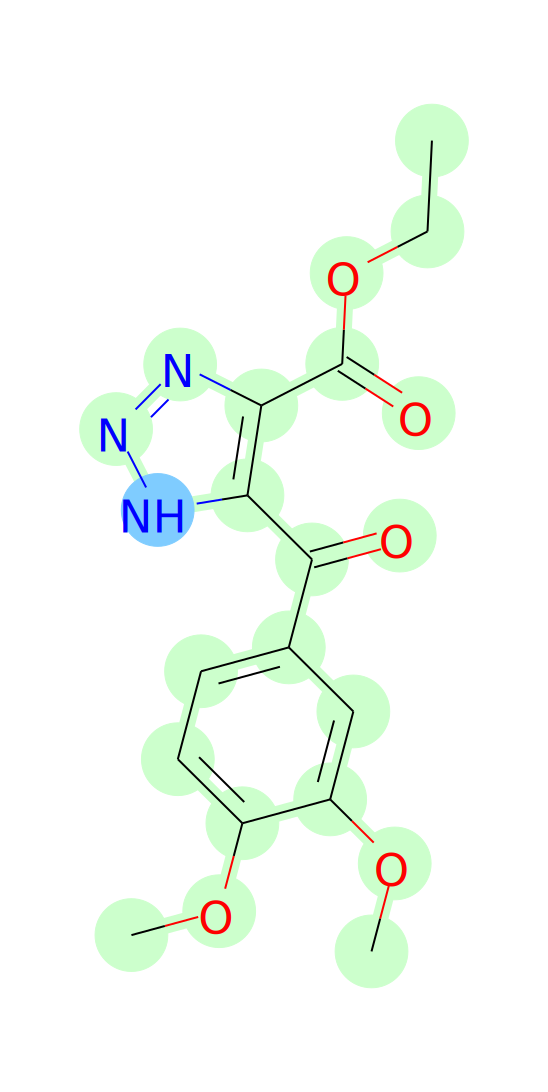

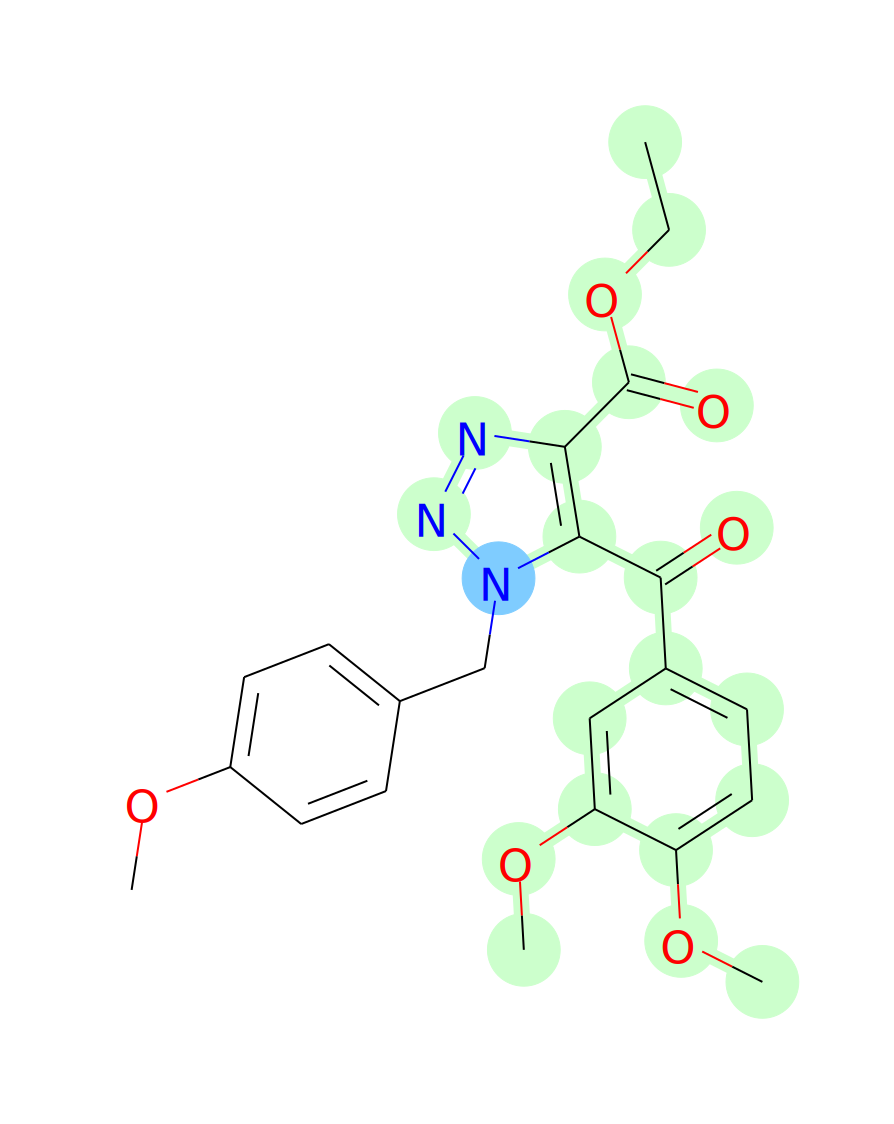

37709
0.12659822


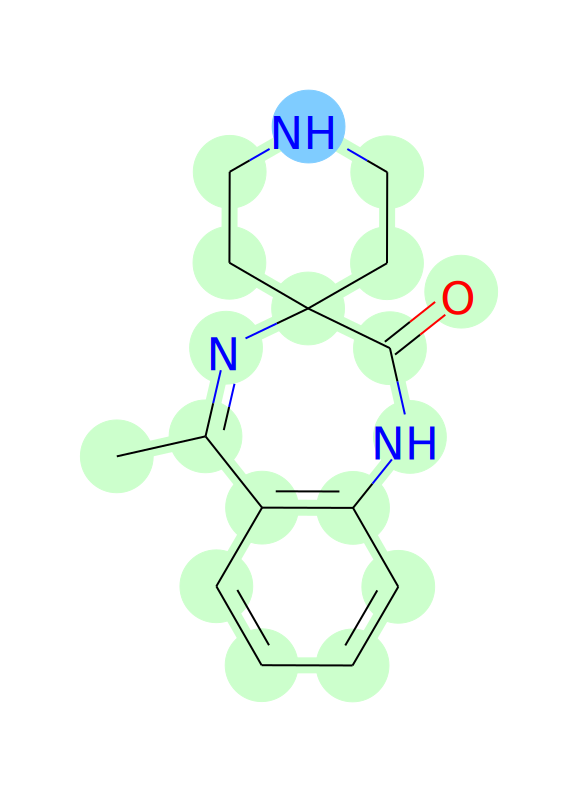

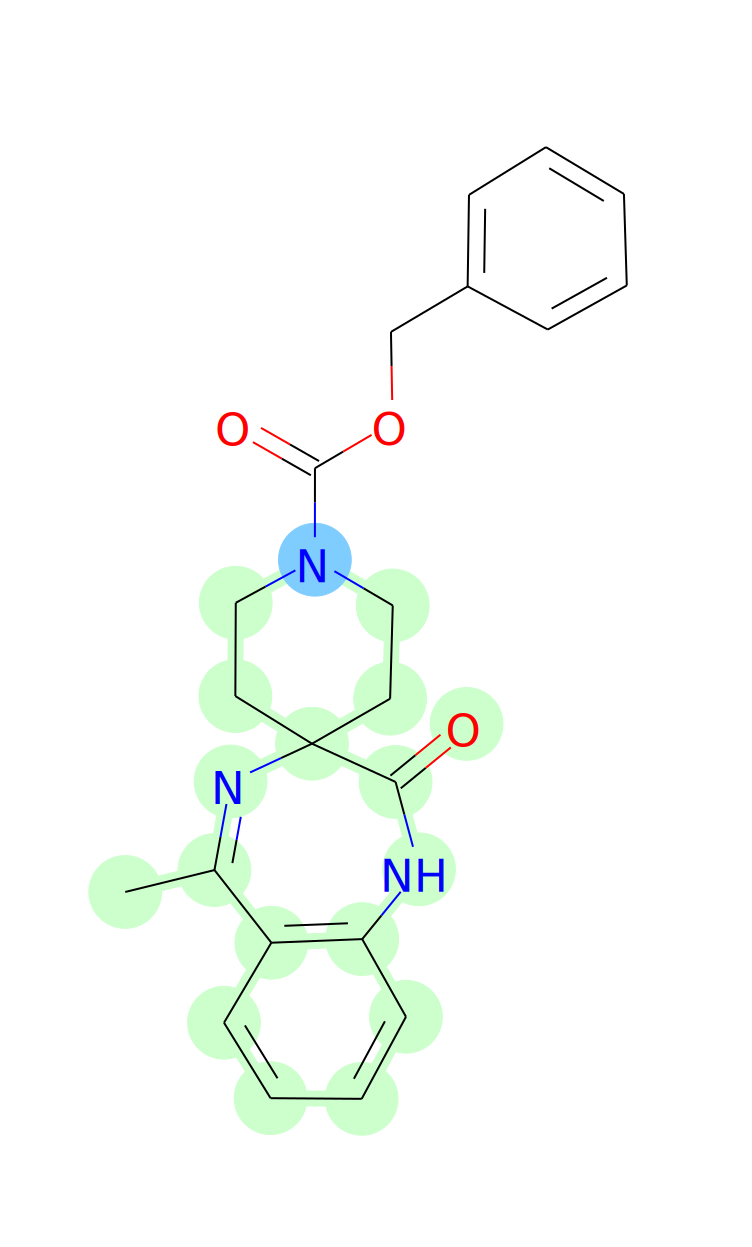

45224
0.14475033


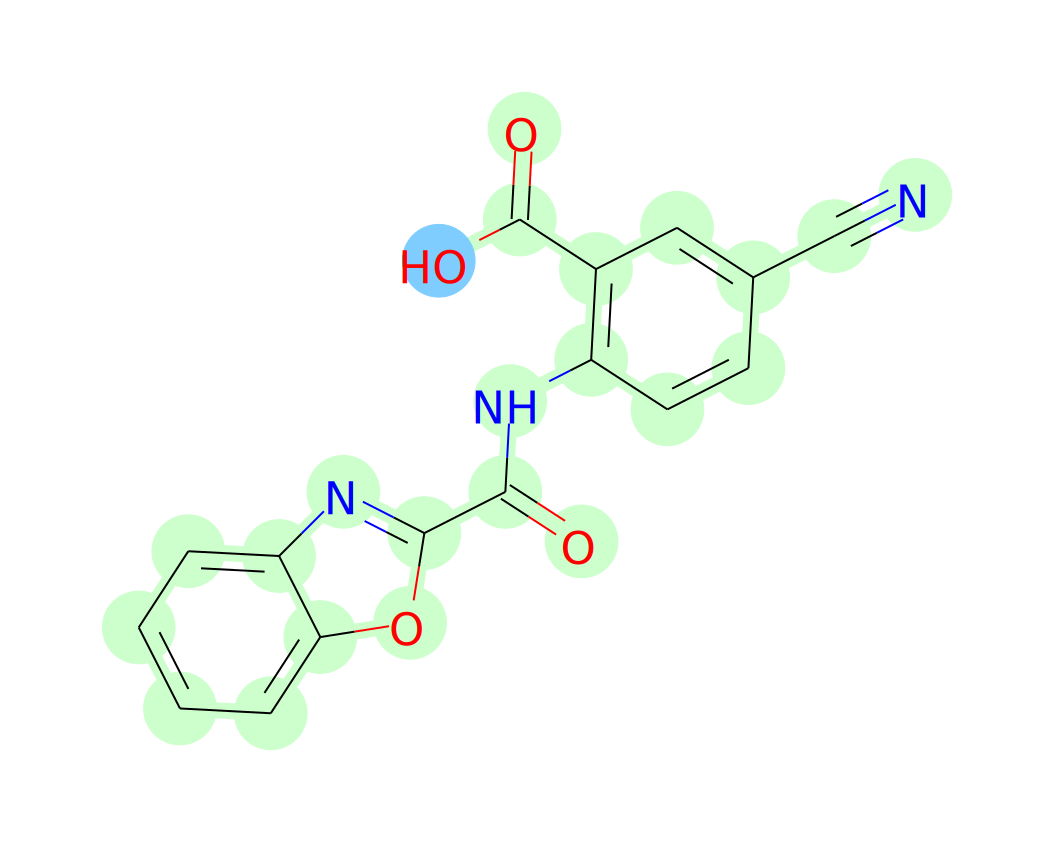

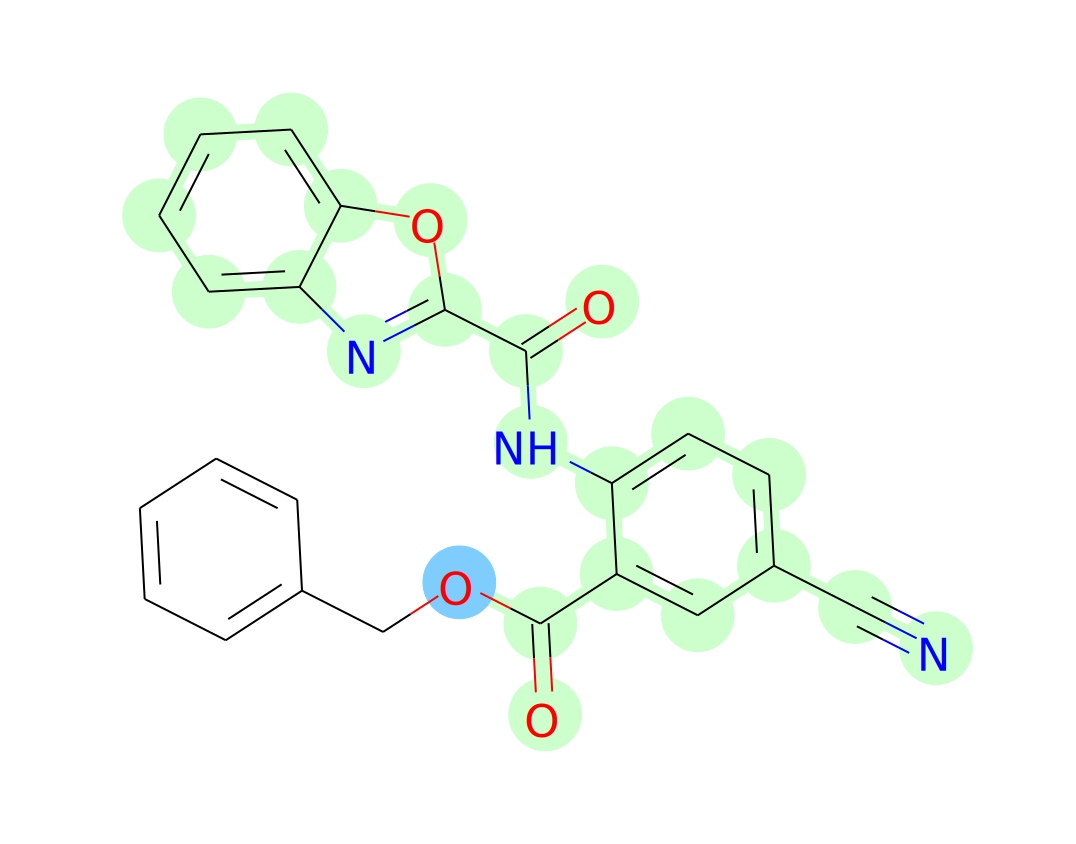

43501
0.2561264


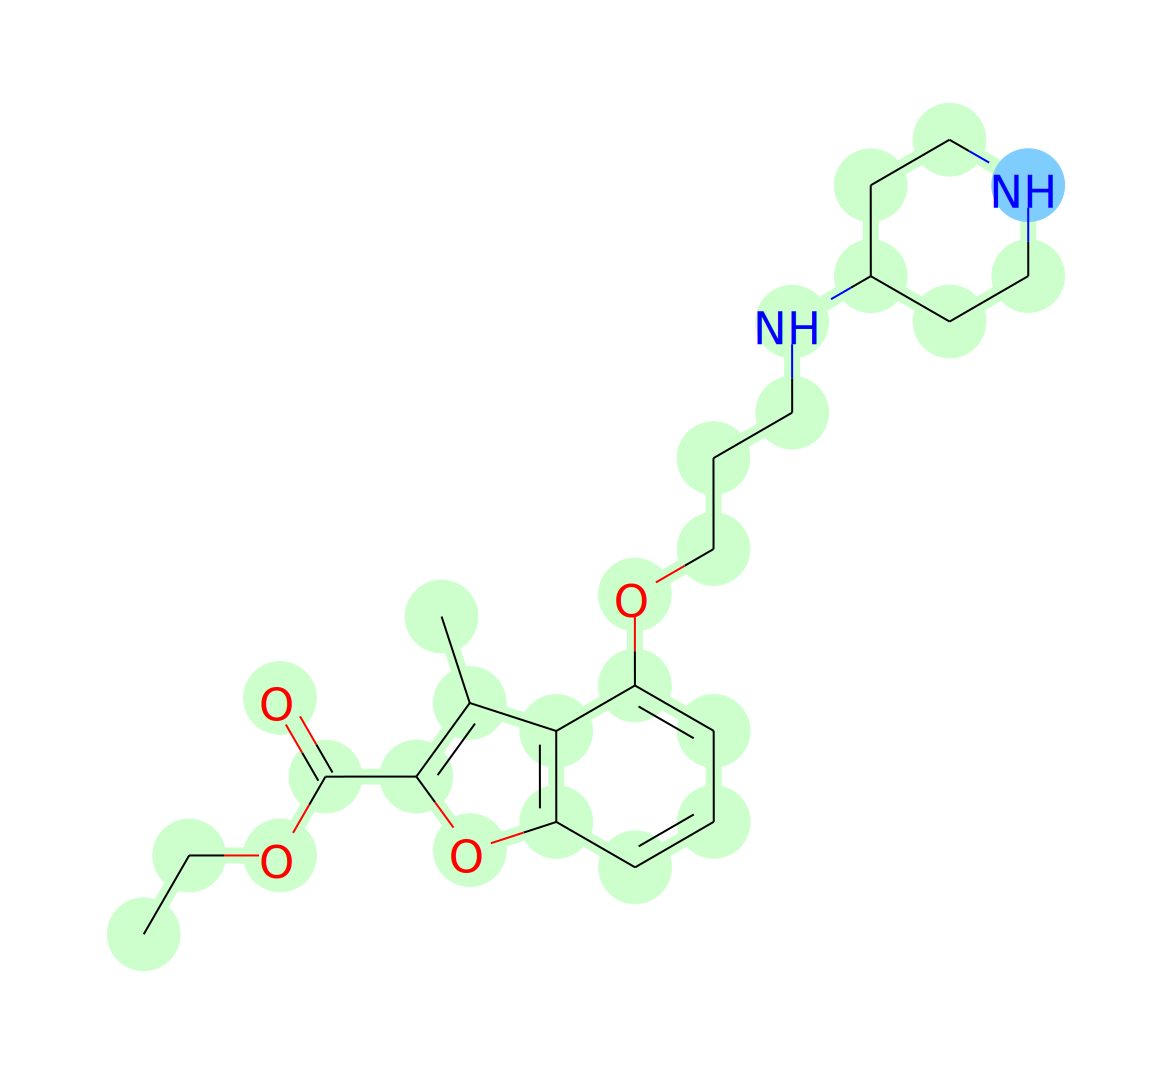

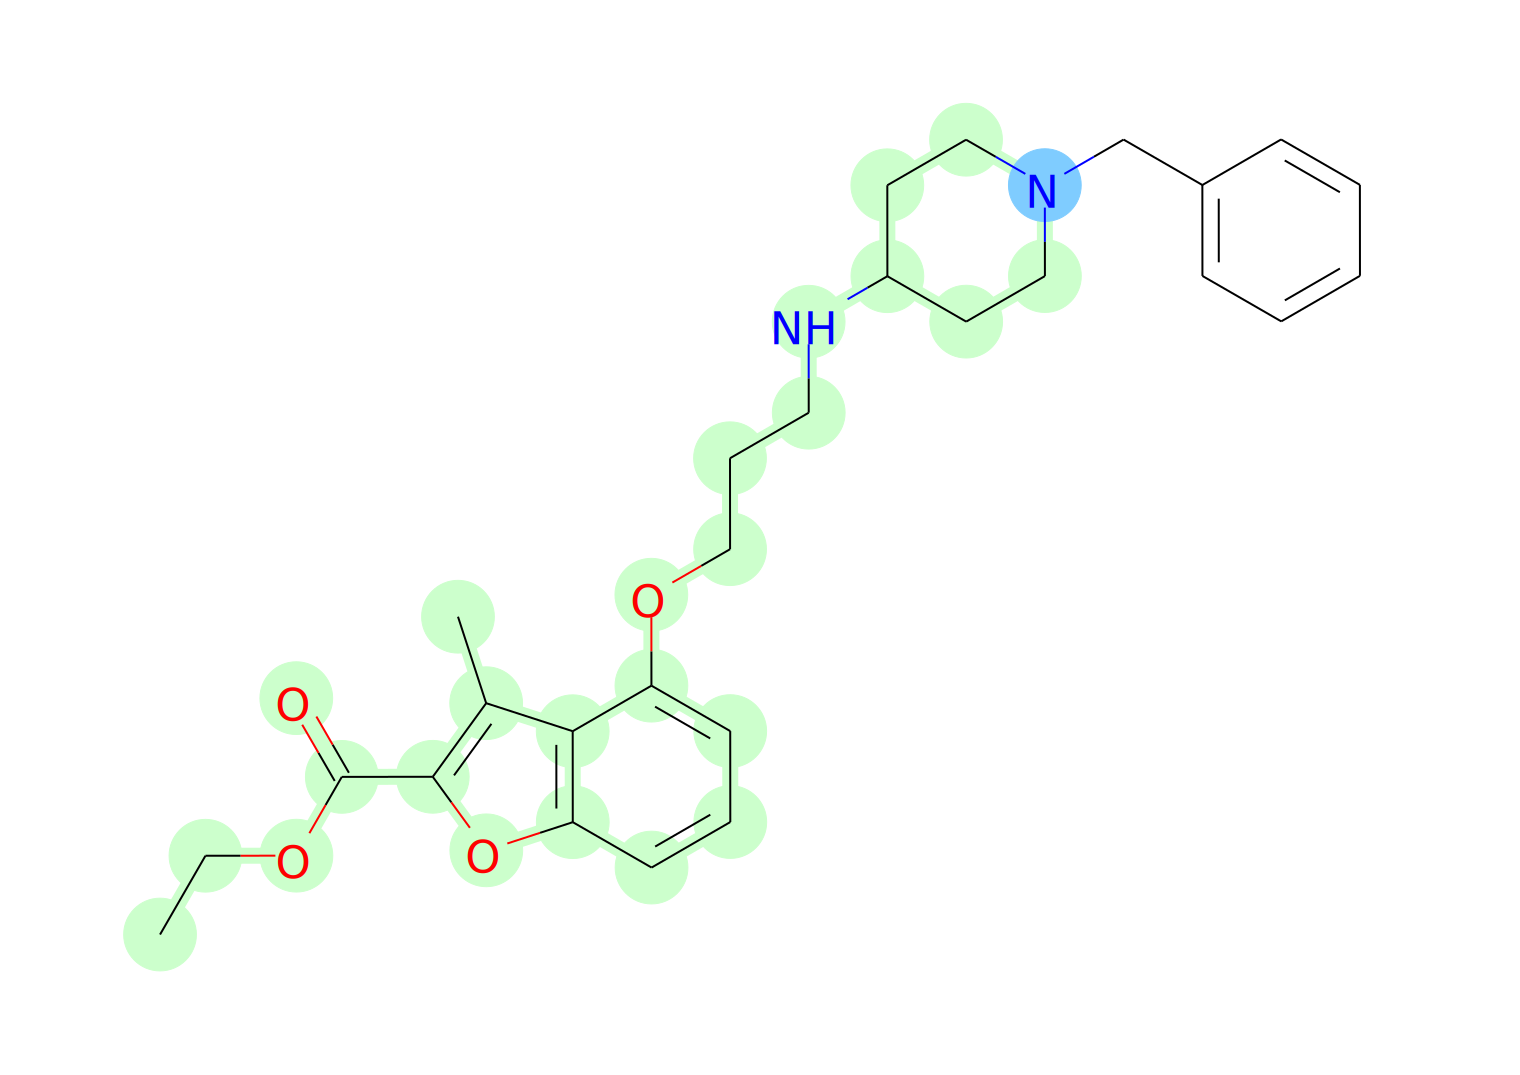

24916
0.82145524


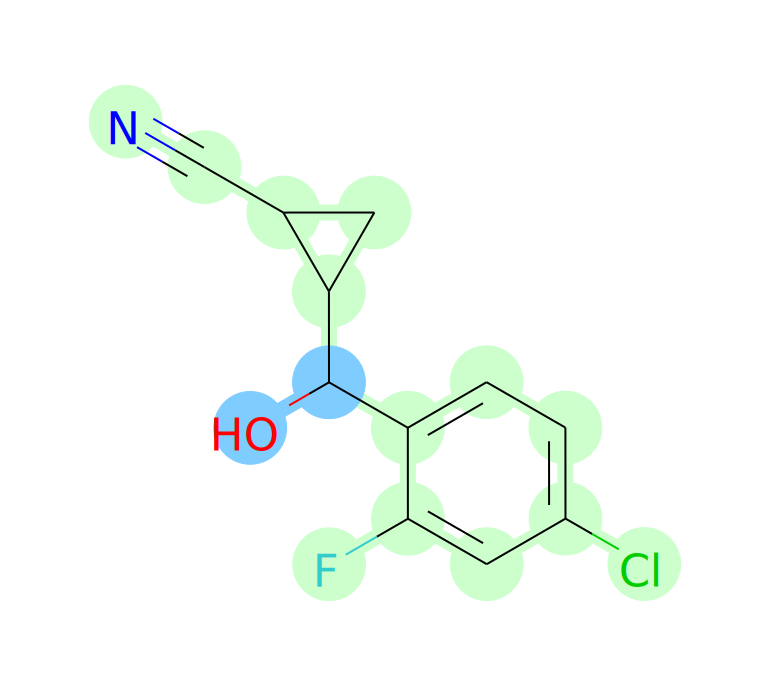

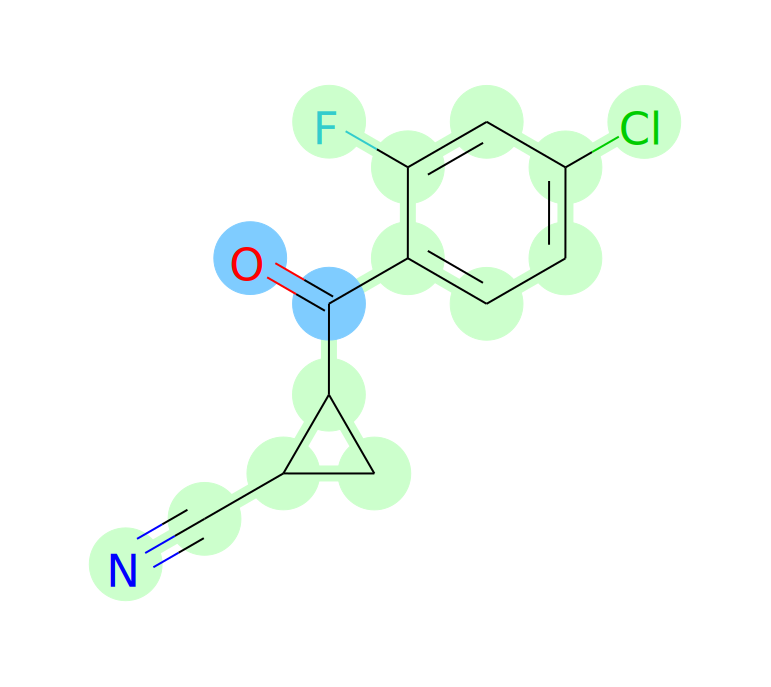

In [41]:
idx = 11
norms = np.linalg.norm(reac_reps - reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5000]])

23890
0.0


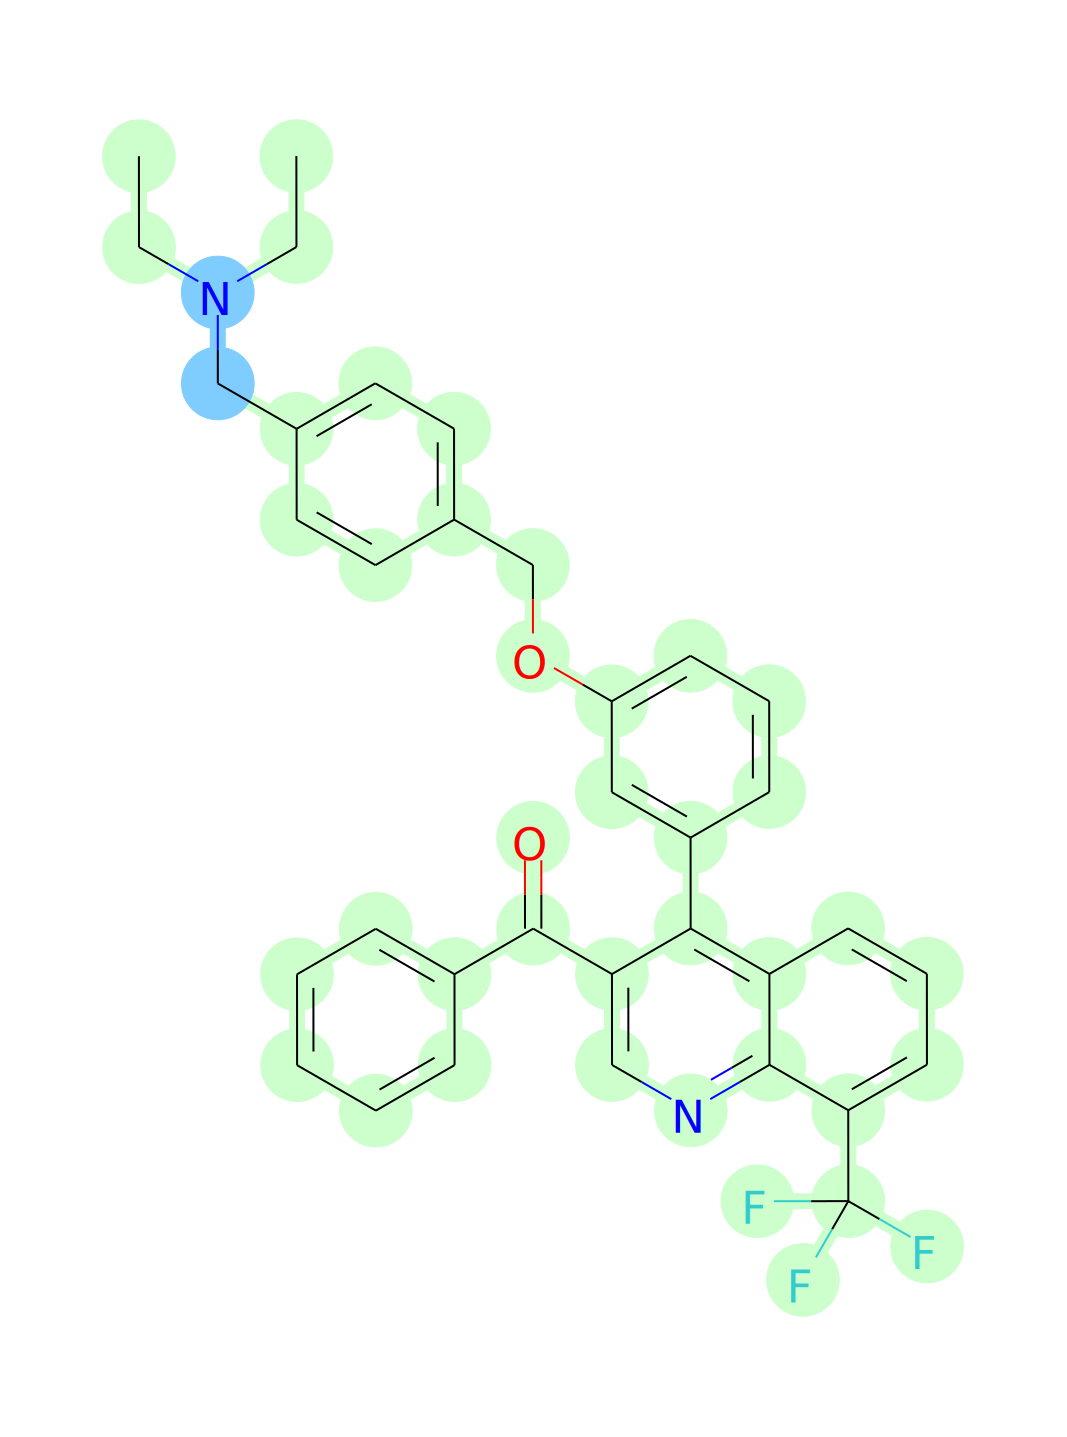

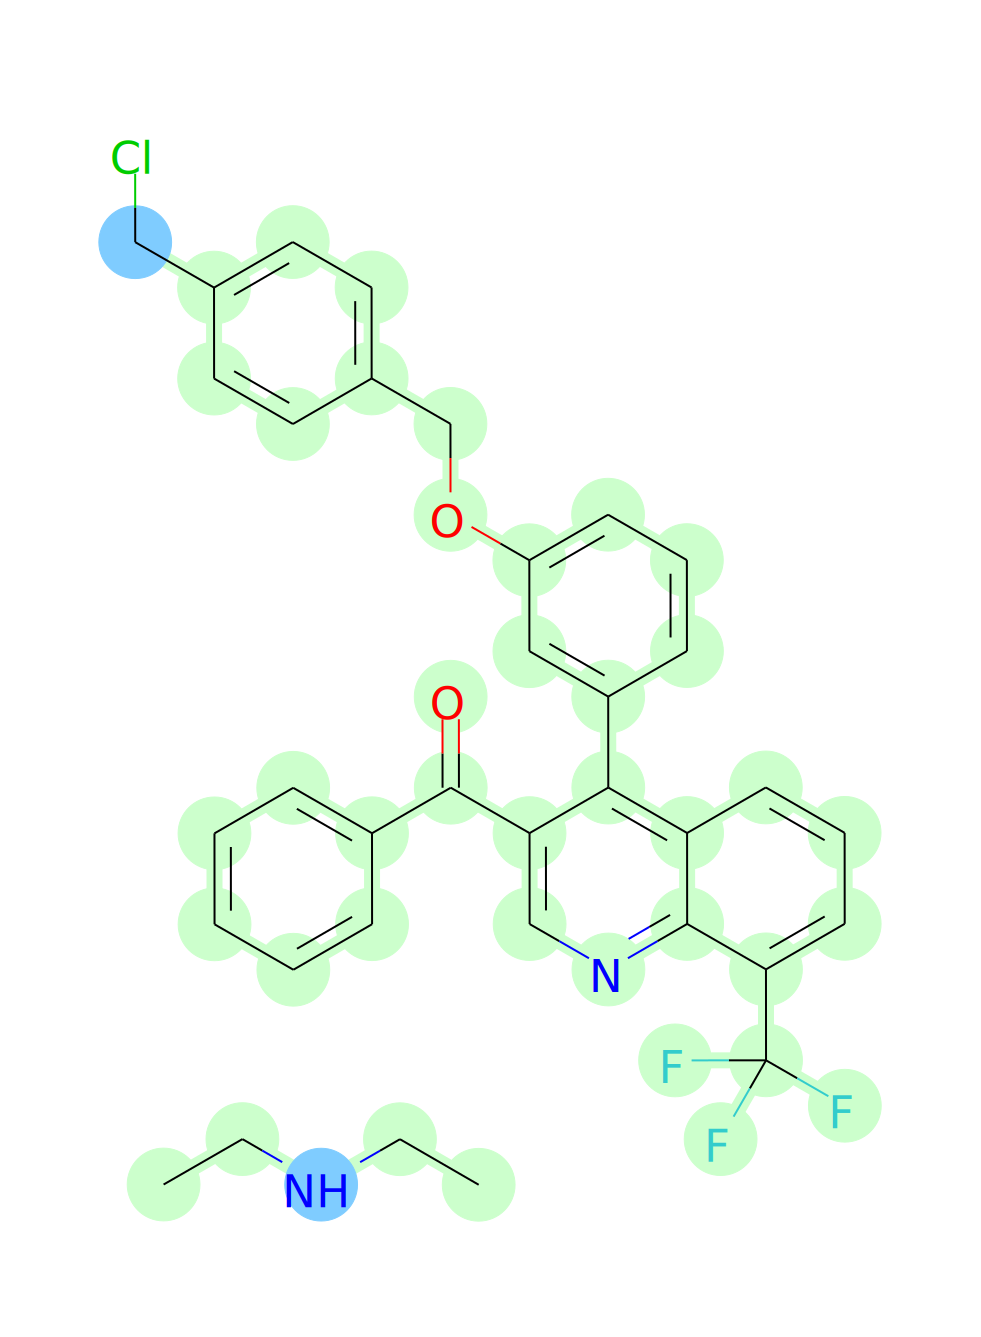

37871
0.12619622


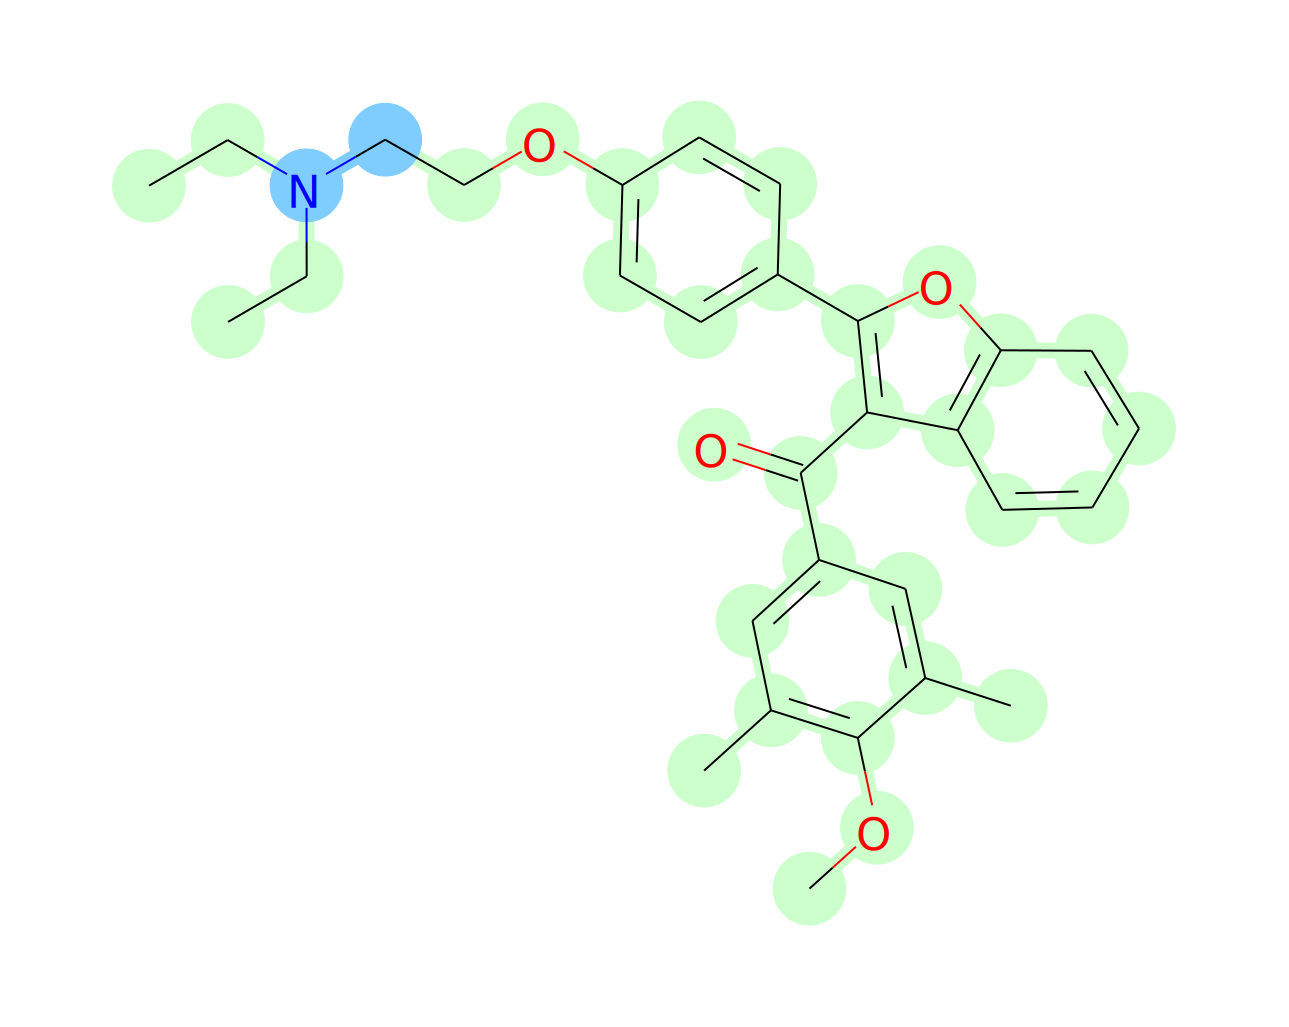

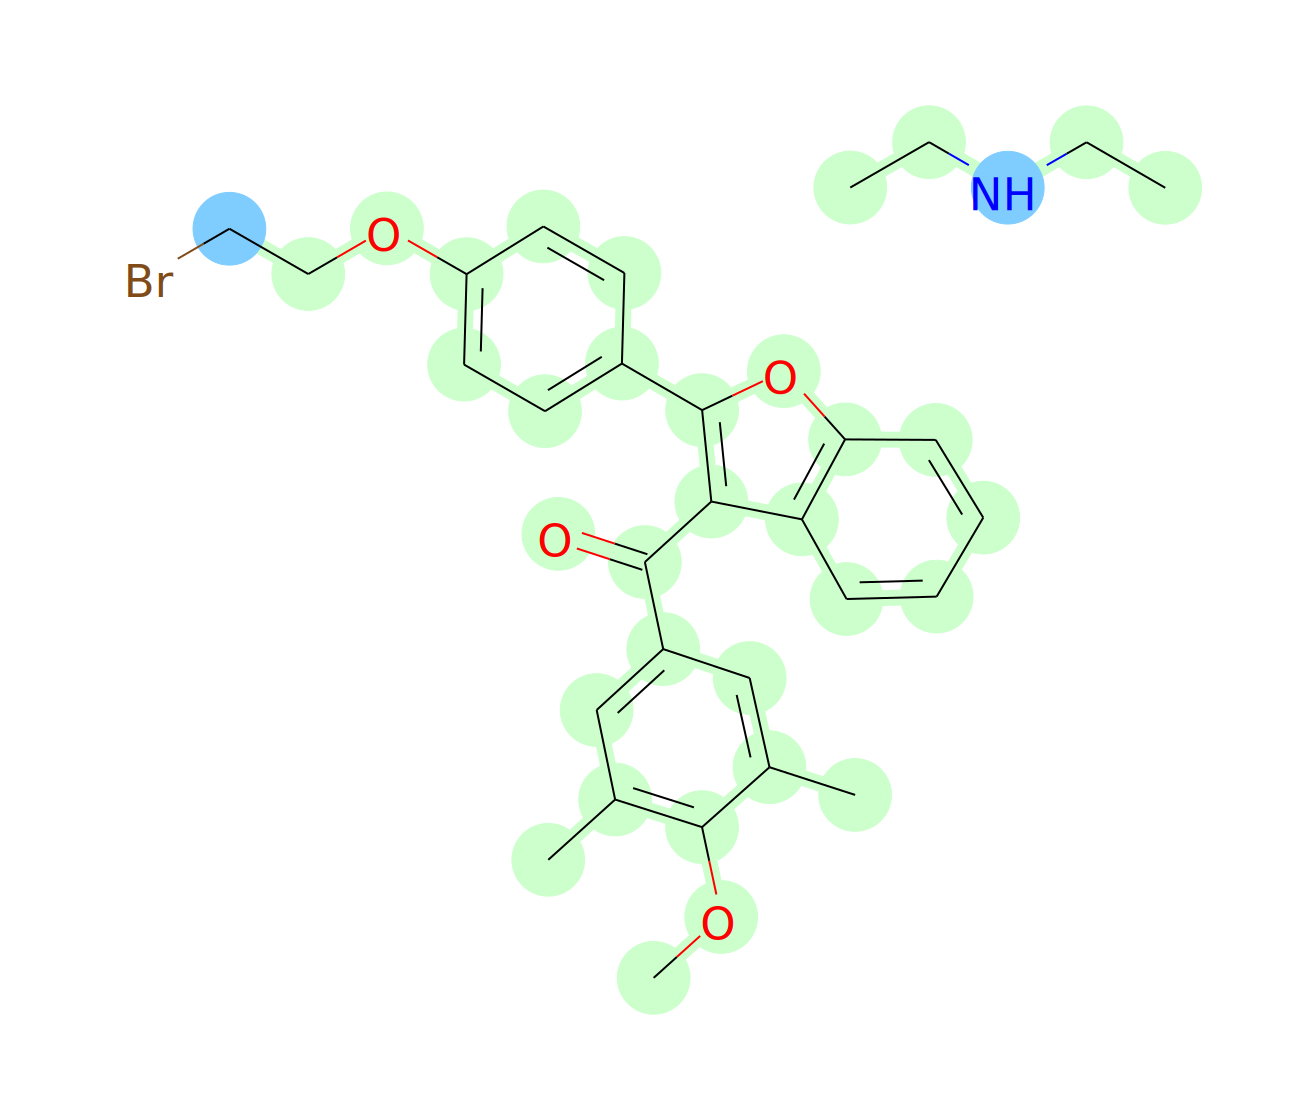

38635
0.1343671


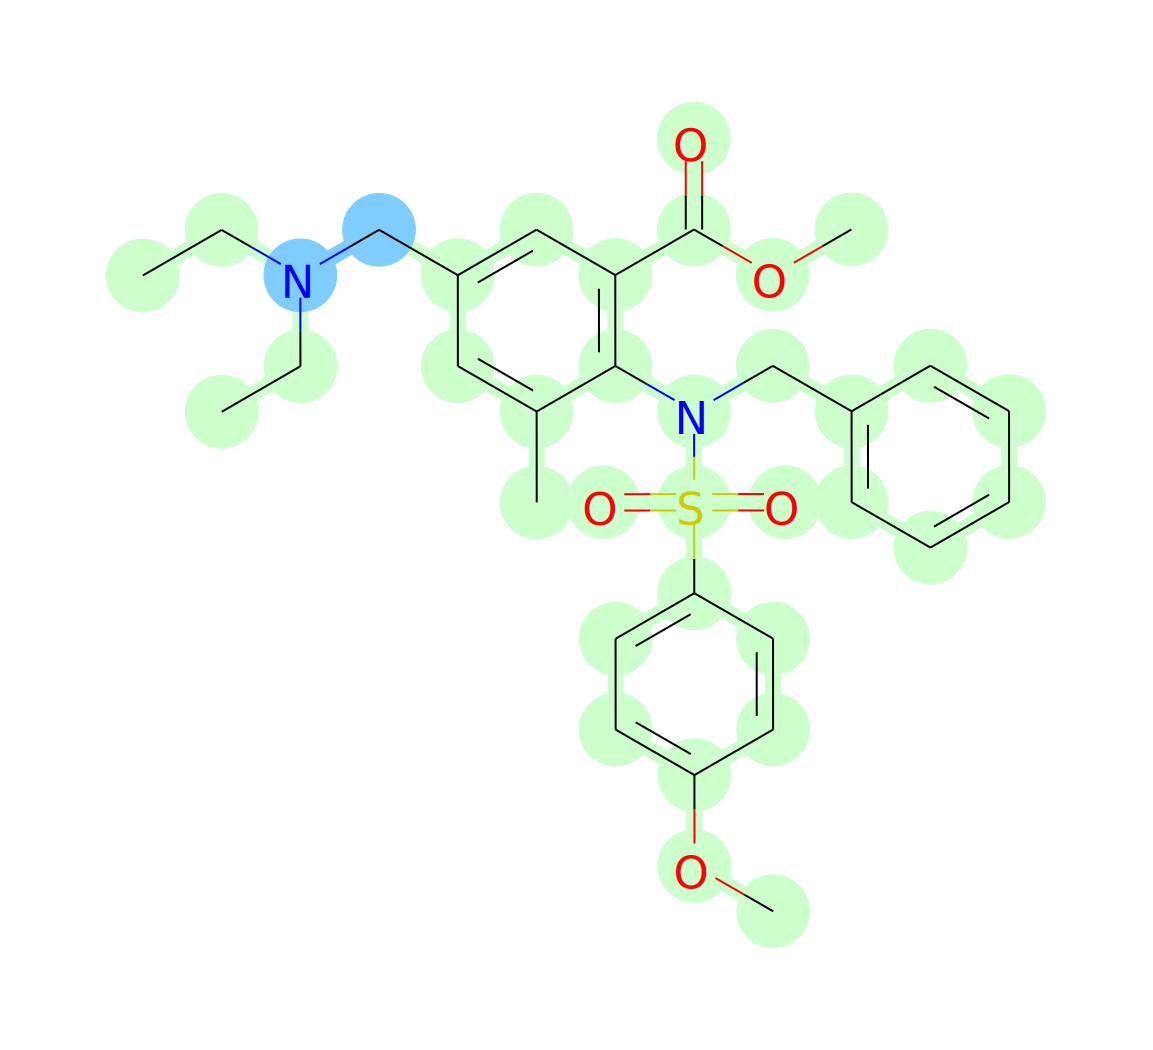

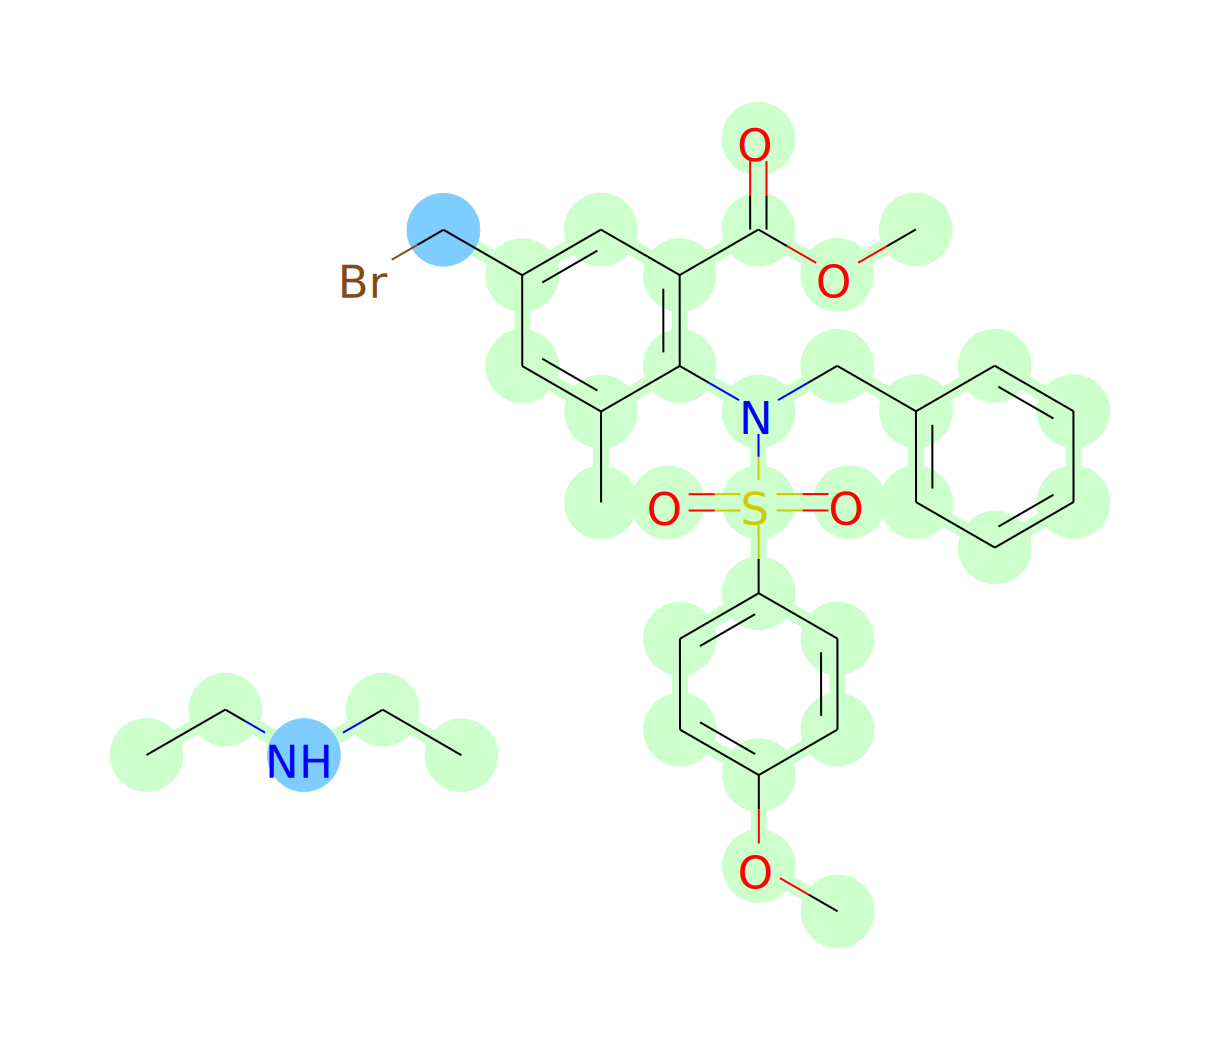

46727
0.25044125


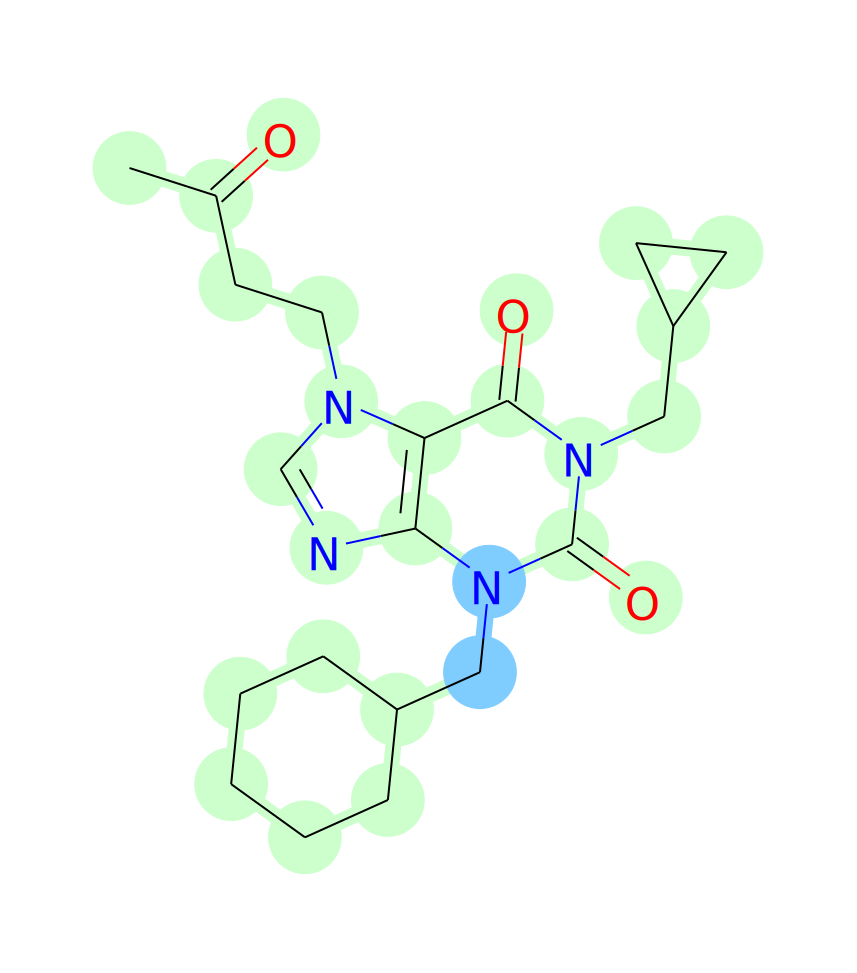

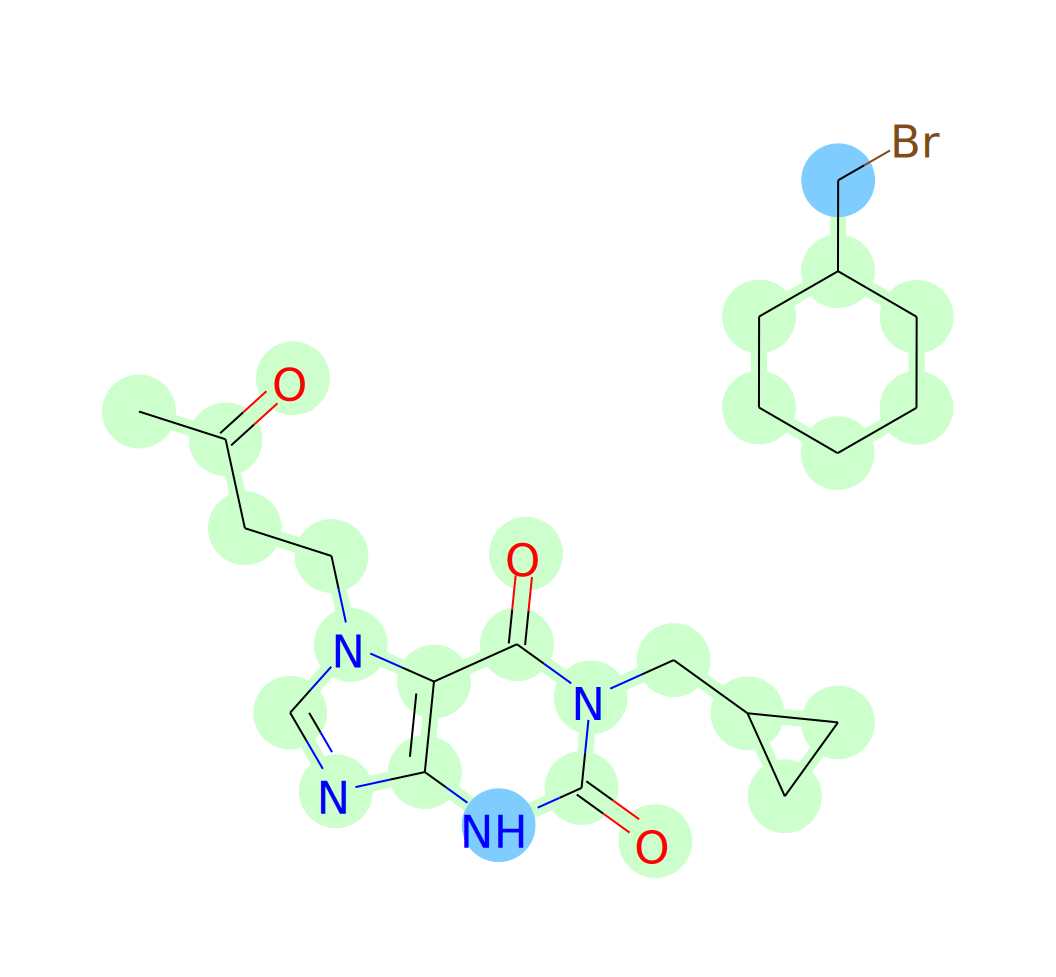

38662
0.7323964


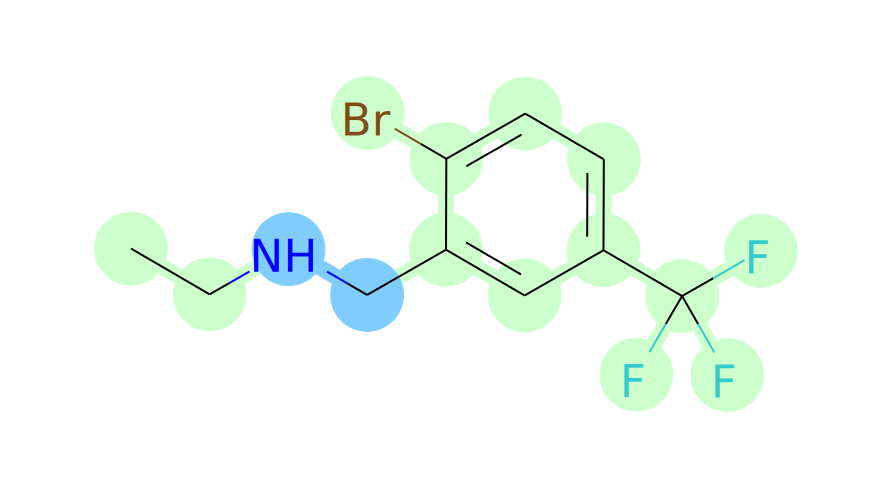

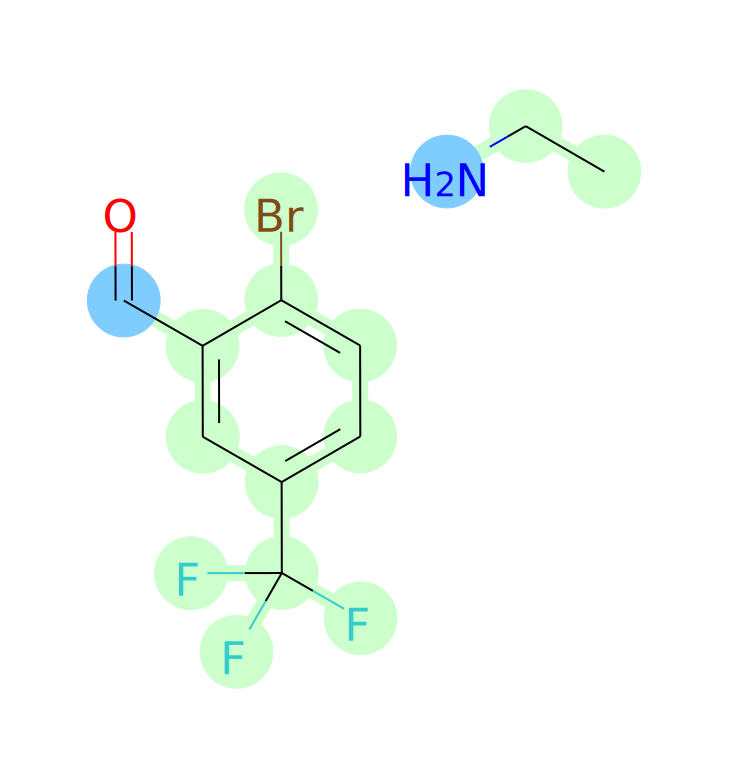

In [42]:
idx = 23890
norms = np.linalg.norm(reac_reps - reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5000]])